# 使用Python提取OpenSees中的单轴材料滞回本构曲线

分享一个自用的OpenSees的单轴材料滞回曲线的提取代码，基于Python语言和OpenSeesPy库编写。滞回模型在抗震领域内用来模拟结构、构件以及材料在循环往复作用下的恢复力和变形之间的关系，更详细的解释可参考相关书籍，譬如陆新征老师的《建筑抗震弹塑性分析》。一个不错的网文也可参考一下，土木吧→神秘的滞回曲线 (360doc.com)。滞回模型在模拟意义上本质上还是一套规则，即事先指定力和变形应该遵循什么样的演变路径来变化，OpenSees提供了非常丰富的单轴滞回模型，所谓单轴就是仅定义于一个方向，本文所分享的就是如何把这个规则提取和可视化出来，目的主要有两个，一是看看OpenSees中定义的这些规则到底长什么样子，包括改变各种参数后怎么变化的；二是有时为了写论文需要，我们需要画出滞回模型示意图，有了数据就可以利用绘图软件制作矢量图，而不必很麻烦的借助CAD等画图软件。本文主要面向python用户，对于科学计算建议安装Anaconda(一个python科学计算和数据分析集成环境，已内置了python以及众多的第三方库)，OpenSeesPy需要另行在Anaconda内安装(非常简单，一行命 pip install --upgrade openseespy即可，可自行百度Aanconda如何安装包)。python是一门易于入门，语法平易近人又优雅的语言，在编写的过程中我尽力去做到让代码简洁和优雅，但能力有限，在代码和专业知识上如果有不足之处请大家纠正。

首先对OpenSees和OpenSeesPy作一个简短的介绍。OpenSees（以下简称ops）是一个主要基于C++开发的开源有限元库，主要面向结构和岩土抗震非线性分析，不过对于一般的有限元模型也应该足够使用，关于ops的入门和使用有一个非常不错的中文博客可供参考学习，详见董翰林博士的博客网址http://www.hanlindong.com/。这里也提供一个英文博客网址https://portwooddigital.com/，由OpenSees核心开发者Michael H. Scott教授创建，里面的博文非常有意思，很值得学习探索。另外，OpenSees官方认定的论坛https://opensees.berkeley.edu/community/viewforum.php?f=9&sid=77440d202a1c396d36f132ea8c72ded9，里面聚集了全世界的ops用户，大家都很热情，尤其是Scott教授非常热情活跃，解答问题非常迅速。

OpenSeesPy是 Minjie Zhu博士和Scott教授 开发的 OpenSees的 python接口库，OpenSeesPy 将Python的易用性和强大的科学计算生态与OpenSees结合了起来，极大促进了OpenSees的发展，其文档主页见 https://openseespydoc.readthedocs.io/en/latest/。这里需要注意的是不管ops的python接口还是最初的tcl接口，其内核都是OpenSees的底层C++库，接口只是方便用户的使用，原则上只要接口设计的正确，二者计算结果应该是一致的，当然也不排除tcl和python本身机制不同导致的结果在转换过程中的微小差别，但应该是可忽略的。当前OpenSeesPy仅支持python内置的对象作为输入，不支持numpy的数据类型，举个例子，python内置的整数(int)和浮点数(float)类型输入到OpenSeesPy函数中是没有问题的，但是numpy本身也提供了int和float类型，输入该类型后会报错 ，需要使用int()和float()显式转换，这一点需要注意。

# 导入必要的库

In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import openseespy.opensees as ops

plt.rcParams['font.family'] = 'Times New Roman'

# 定义位移加载模式

这里我们使用基于位移加载的循环Pushover分析来提取单轴材料的滞回曲线，需要事先定义一个加载模式。
加载模式采用比例增加的方式，先定义一个最大位移，然后从0成比例的逐渐增加到该最大位移，加载过程中是往复推的，由一系列循环组成，具体定义见代码。
注意，滞回本构在代码中说到底就是一套规则，所以上面的位移和力就是广义位移和广义力，既可以包括应变-应力、曲率-弯矩，也可包括常规意义上的位移-力。
这意味着我们在提取滞回曲线时可以将最大位移设为任意值，特征点可以按最大位移的比例来设定即可。

In [16]:
# 定义 位移加载模式
def cycle_generate(profile_upper, profile_below, n_in_cycle):
    """
    profile_upper: 正向单调加载模式
    profile_below： 反向单调加载模式
    n_in_cycle： 每个循环的等幅次数
    """
    pattern = [0]          # 位移模式并初始化为0
    for disp1, disp2 in zip(profile_upper[1:], profile_below[1:]):
        for j in range(n_in_cycle):
            pattern.extend([disp1, disp2])
    pattern.append(0)      # 最后归0
    pattern = np.array(pattern)
    return pattern

max_deform = 0.1     # 最终的正向目标加载位移
min_deform = -0.1    # 最终的反向目标加载位移，正反分别设置可模拟不对称循环
n_cycle = 10         # 变幅循环次数，实际上总的循环次数为 n_in_cycle * n_cycle
# 如下定义4种位移加载模式
profile_upper = np.linspace(0, max_deform, n_cycle)
profile_below = np.linspace(0, min_deform, n_cycle)
pattern1 = cycle_generate(profile_upper, profile_below, n_in_cycle=1)
pattern2 = cycle_generate(profile_upper, profile_below, n_in_cycle=3)
profile_upper = np.linspace(0, max_deform, n_cycle)
profile_below = np.zeros(n_cycle)
pattern3 = cycle_generate(profile_upper, profile_below, n_in_cycle=1)
profile_upper = np.zeros(n_cycle) - 1e-3
profile_below = np.linspace(0, min_deform, n_cycle)
pattern4 = cycle_generate(profile_upper, profile_below, n_in_cycle=1)

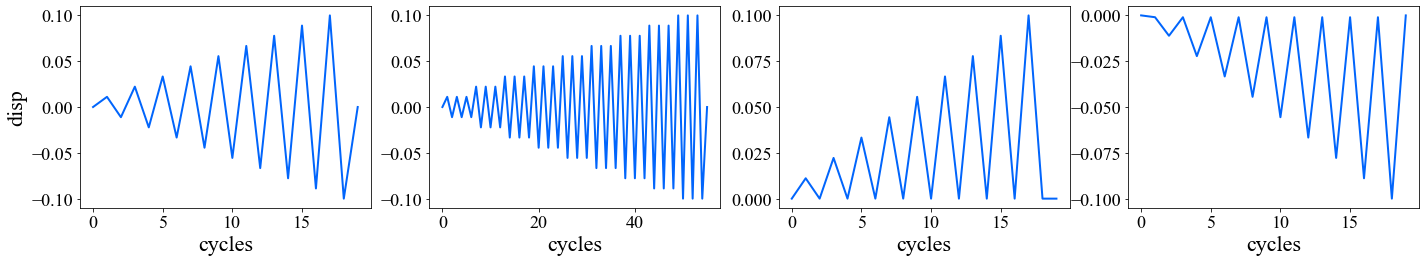

In [17]:
# 位移加载模式示意
patterns = [pattern1, pattern2, pattern3, pattern4]
fig,axs = plt.subplots(1,4, figsize=(24,6*0.618))
for i, pattern_ in enumerate(patterns):
    ax = axs[i]
    ax.plot(pattern_, c='#0165fc', lw=2)
    ax.set_xlabel('cycles',fontsize=22)
    ax.tick_params(labelsize=18)
axs[0].set_ylabel('disp',fontsize=22)
plt.show();  

# 提取滞回曲线

In [18]:
def hysteretic_curve(pattern, material, num_incr=100):
    """
    material: 材料命令字符串
    num_incr: 每个循环内的分析步数目，若不收敛可加大
    """
    ops.wipe()
    ops.model("basic", "-ndm", 1, "-ndf", 1)
    
    # 设置材料
    exec(material)
    
    # ------------------------------------------------------
    # 建立节点与单元
    # ------------------------------------------------------
    ops.node(1, 0.0)
    ops.node(2, 0.0)
    ops.fix(1, 1)
    ops.element("zeroLength", 1, 1, 2, "-mat", 1, "-dir", 1)

    # ------------------------------------------------------
    # 基于位移的循环pushover
    # ------------------------------------------------------
    # %%  分析
    ops.timeSeries('Linear', 1)
    ops.pattern('Plain', 1, 1)
    ops.load(2, 1)
    ops.constraints("Plain")
    ops.numberer("RCM")
    ops.system("BandGeneral")
    ops.test("EnergyIncr", 1.0e-10, 10, 0)
    ops.algorithm('Newton')
    nodedisp = []    # 保存节点变形
    F = []           # 保存节点力
    for i in range(len(pattern)-1):
        Dincr = (pattern[i+1] - pattern[i])/num_incr
        ops.integrator('DisplacementControl',  2,   1, Dincr)
        ops.analysis('Static')
        for j in range(num_incr):
            ops.analyze(1)
            F.append(ops.getTime())
            nodedisp.append(ops.nodeDisp(2, 1))
    ops.wipe()
    nodedisp = np.array(nodedisp)
    F = np.array(F)
    return nodedisp, F

## Hysteretic Material

In [19]:
K = 1e4           # 单自由度系统的初始刚度，线性刚度，kN/m
alpha1_K = 0.2    # 第二段直线斜率与初始刚度的比值
alpha2_K = -0.3   # 第三段直线斜率与初始刚度的比值，可正可负，正代表继续硬化，零代表保持水平，负代表退化
xy = 0.2 * max_deform
xd = 0.5 * max_deform
xu = 0.75 * max_deform
Fy = K * xy
Fd = Fy + (xd - xy) * alpha1_K * K
Fu = Fd + (xu - xd) * alpha2_K * K
# 以下为滞回规则参数，可改变其值看滞回曲线的变化
pinchX = 0.5     # 捏缩效应的参数
pinchY = 0.5     #
damage1 = 0.0    # 强度退化的参数
damage2 = 0.0
beta = 0.5       # 刚度退化参数
material1 = """ops.uniaxialMaterial("Hysteretic", 1, *[Fy, xy], *[Fd, xd], *[Fu, xu],
                                *[-Fy, -xy], *[-Fd, -xd], *[-Fu, -xu],
                                pinchX, pinchY, damage1, damage2, beta)"""
disp1, F1 = hysteretic_curve(pattern1, material1)

# 如下修改表征强度退化的参数
damage1 = 0.5 
damage2 = 0.5
material2 = """ops.uniaxialMaterial("Hysteretic", 1, *[Fy, xy], *[Fd, xd], *[Fu, xu],
                                *[-Fy, -xy], *[-Fd, -xd], *[-Fu, -xu],
                                pinchX, pinchY, damage1, damage2, beta)"""
disp2, F2 = hysteretic_curve(pattern1, material2)

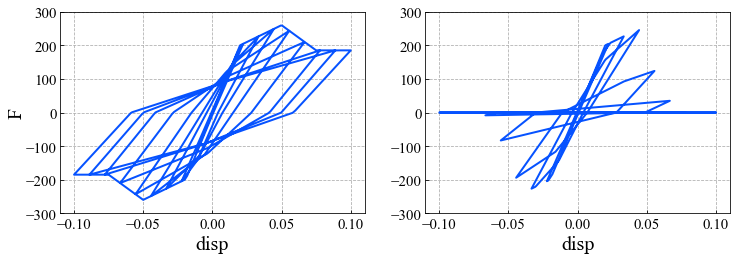

In [20]:
F_disp = [(disp1, F1), (disp2, F2)]
fig, axs = plt.subplots(1, 2, figsize=(12,6*0.618))
for i, value in enumerate(F_disp):
    disp, F = value
    ax = axs[i]
    ax.plot(disp, F, c='#0652ff', lw=2)
    ax.set_xlabel('disp', fontsize=20)
    ax.tick_params(direction='in', labelsize=15)
    ax.grid(True, zorder=-50, ls='--', lw=0.8)
    ax.set_ylim(-300,300)
axs[0].set_ylabel('F', fontsize=20, labelpad=0.5)
plt.show();

## concrete 01 材料

WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() 

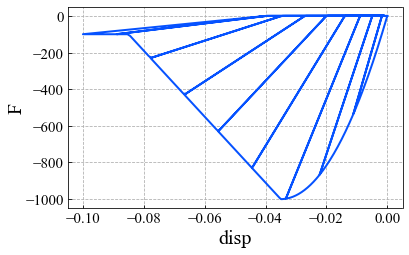

In [21]:
epsc0 = min_deform * 0.35 
epsU = min_deform * 0.85
fpc = -1000 
fpcu = -100 
material = """ops.uniaxialMaterial('Concrete01', 1, fpc, epsc0, fpcu, epsU)"""
disp, F = hysteretic_curve(pattern4, material)

fig, ax = plt.subplots(figsize=(6,6*0.618))
ax.plot(disp, F, c='#0652ff', lw=2)
ax.set_xlabel('disp', fontsize=20)
ax.set_ylabel('F', fontsize=20, labelpad=0.5)
ax.tick_params(direction='in', labelsize=15)
ax.grid(True, zorder=-50, ls='--', lw=0.8)
plt.show();
np.savetxt('_disp.txt', disp)
np.savetxt('_F.txt', F)

## concreteD 材料

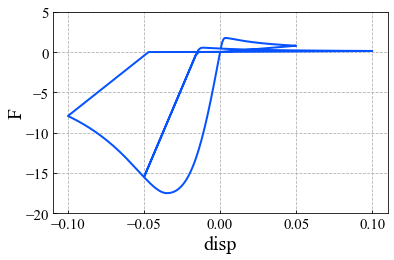

In [8]:
# 建立 concreteD 材料, 该材料基于中国混凝土结构设计规范
epsc = -max_deform * 0.35
epst = max_deform * 0.35 / 10
Ec = 1000
fc = Ec * epsc / 2
ft = Ec * epst / 2
alphac = 1.0
alphat = 0.1
cesp = 0.25
etap = 1.15
material = """ops.uniaxialMaterial('ConcreteD', 1, fc, epsc, ft, epst, Ec, alphac, alphat, cesp, etap)"""
disp, F = hysteretic_curve(pattern1, material)

fig, ax = plt.subplots(figsize=(6,6*0.618))
ax.plot(disp, F, c='#0652ff', lw=2)
ax.set_xlabel('disp', fontsize=20)
ax.set_ylabel('F', fontsize=20, labelpad=0.5)
ax.tick_params(direction='in', labelsize=15)
ax.grid(True, zorder=-50, ls='--', lw=0.8)
ax.set_ylim(-20,5)
plt.show();

## steel01 材料

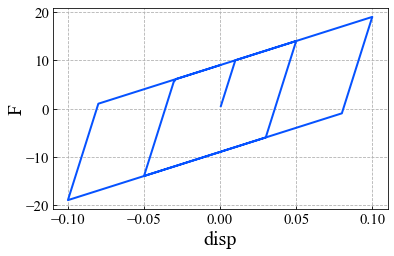

In [9]:
# 建立 steel01 材料, 其余的硬化参数<a1, a2, a3, a4>请参照官网，可测试其影响，此处省略
xy = max_deform * 0.1
E0 = 1000
Fy = E0 * xy
b = 0.1
material = """ops.uniaxialMaterial('Steel01', 1, Fy, E0, b)"""
disp, F = hysteretic_curve(pattern1, material)

fig, ax = plt.subplots(figsize=(6,6*0.618))
ax.plot(disp, F, c='#0652ff', lw=2)
ax.set_xlabel('disp', fontsize=20)
ax.set_ylabel('F', fontsize=20, labelpad=0.5)
ax.tick_params(direction='in', labelsize=15)
ax.grid(True, zorder=-50, ls='--', lw=0.8)
plt.show();
np.savetxt('_disp.txt', disp)
np.savetxt('_F.txt', F)

## steel01 材料 + maxmin

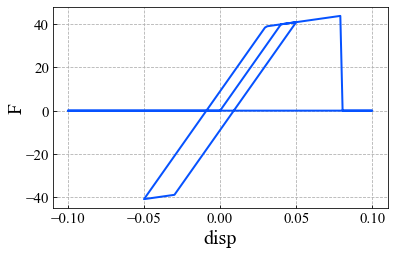

In [10]:
# 建立 steel01 材料, + maxmin材料，maxmin主要用来防止材料无限强化
xy = max_deform * 0.4
E0 = 1000
Fy = E0 * xy
b = 0.1
minStrain = 0.8 * min_deform
maxStrain = 0.8 * max_deform
material = """
ops.uniaxialMaterial('Steel01', 2, Fy, E0, b)
ops.uniaxialMaterial('MinMax', 1, 2, '-min', minStrain, '-max', maxStrain)
"""
disp, F = hysteretic_curve(pattern1, material)

fig, ax = plt.subplots(figsize=(6,6*0.618))
ax.plot(disp, F, c='#0652ff', lw=2)
ax.set_xlabel('disp', fontsize=20)
ax.set_ylabel('F', fontsize=20, labelpad=0.5)
ax.tick_params(direction='in', labelsize=15)
ax.grid(True, zorder=-50, ls='--', lw=0.8)
plt.show();

## ReinforcingSteel 材料

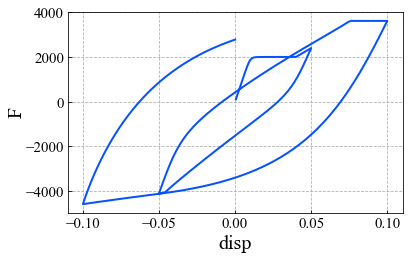

In [11]:
Es = 2e5
Esh = 0.2 * Es
xy = 0.1 * max_deform
eps_sh = 0.4 * max_deform
eps_ult = 0.8 * max_deform
fy = Es * xy
fu = fy + (eps_ult - eps_sh) * Esh
material = """ops.uniaxialMaterial('ReinforcingSteel', 1, fy, fu, Es, Esh, eps_sh, eps_ult)"""
disp, F = hysteretic_curve(pattern1, material)

fig, ax = plt.subplots(figsize=(6,6*0.618))
ax.plot(disp, F, c='#0652ff', lw=2)
ax.set_xlabel('disp', fontsize=20)
ax.set_ylabel('F', fontsize=20, labelpad=0.5)
ax.tick_params(direction='in', labelsize=15)
ax.grid(True, zorder=-50, ls='--', lw=0.8)
plt.show();

## HyperbolicGapMaterial 材料

WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() 

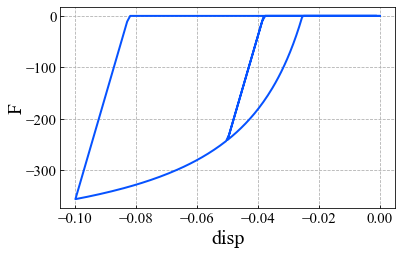

In [12]:
# 该材料常用来模拟桥台的回填土
Kmax, Kur, Rf, Fult, gap = 20300, 20300, 0.7, -326, -0.0254
material = """ops.uniaxialMaterial('HyperbolicGapMaterial', 1, Kmax, Kur, Rf, Fult, gap)"""
disp, F = hysteretic_curve(pattern4, material)

fig, ax = plt.subplots(figsize=(6,6*0.618))
ax.plot(disp, F, c='#0652ff', lw=2)
ax.set_xlabel('disp', fontsize=20)
ax.set_ylabel('F', fontsize=20, labelpad=0.5)
ax.tick_params(direction='in', labelsize=15)
ax.grid(True, zorder=-50, ls='--', lw=0.8)
plt.show();

## Hysteretic Material + HyperbolicGapMaterial

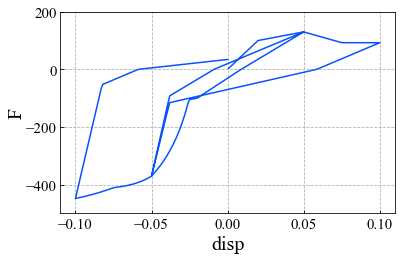

In [13]:
# 譬如用来模拟桥台桩基和桥台填土的并联，以此考虑桥台纵向上的力-位移本构
K = 5e3  # 单自由度系统的初始刚度，线性刚度，kN/m
alpha1_K = 0.2  # 第二段直线斜率与初始刚度的比值
alpha2_K = -0.3  # 第三段直线斜率与初始刚度的比值，可正可负，正代表继续硬化，零代表保持水平，负代表退化
xy = 0.2 * max_deform
xd = 0.5 * max_deform
xu = 0.75 * max_deform
Fy = K * xy
Fd = Fy + (xd - xy) * alpha1_K * K
Fu = Fd + (xu - xd) * alpha2_K * K
# 以下为滞回规则参数，可改变其值看滞回曲线的变化
pinchX = 1  # 捏缩效应的参数
pinchY = 1  #
damage1 = 0  # 强度退化的参数
damage2 = 0
beta = 0.5  # 刚度退化参数
Kmax, Kur, Rf, Fult, gap = 20300, 20300, 0.7, -326, -0.0254
material = """
ops.uniaxialMaterial("Hysteretic", 2, *[Fy, xy], *[Fd, xd], *[Fu, xu],
                        *[-Fy, -xy], *[-Fd, -xd], *[-Fu, -xu],
                        pinchX, pinchY, damage1, damage2, beta)
ops.uniaxialMaterial('HyperbolicGapMaterial', 3, Kmax, Kur, Rf, Fult, gap)
# 并联
ops.uniaxialMaterial('Parallel', 1, *[2, 3])
"""
disp, F = hysteretic_curve(pattern1, material)

fig, ax = plt.subplots(figsize=(6,6*0.618))
ax.plot(disp, F, c='#0652ff', lw=1.5)
ax.set_xlabel('disp', fontsize=20)
ax.set_ylabel('F', fontsize=20, labelpad=0.5)
ax.tick_params(direction='in', labelsize=15)
ax.grid(True, zorder=-50, ls='--', lw=0.8)
ax.set_ylim(-500, 200)
plt.show();

## ImpactMaterial 材料

WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0
WARNING BandGenLinLapackSolver::solve() 

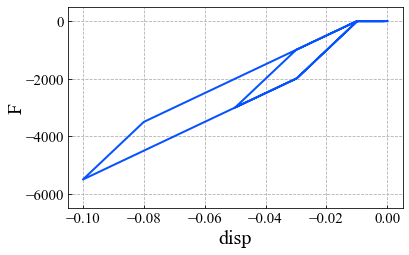

In [14]:
# 常用来模拟主梁之间的冲击
K1, K2 = 1E5, 5E4
sigy, gap = -0.2 * max_deform, -0.1 * max_deform
material = """ops.uniaxialMaterial('ImpactMaterial', 1, K1, K2, sigy, gap)"""
disp, F = hysteretic_curve(pattern4, material)

fig, ax = plt.subplots(figsize=(6,6*0.618))
ax.plot(disp, F, c='#0652ff', lw=2)
ax.set_xlabel('disp', fontsize=20)
ax.set_ylabel('F', fontsize=20, labelpad=0.5)
ax.tick_params(direction='in', labelsize=15)
ax.grid(True, zorder=-50, ls='--', lw=0.8)
ax.set_ylim(-6500,500)
plt.show();

## PySimple1 材料

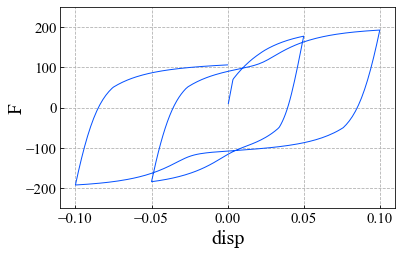

In [15]:
# 常用来模拟 桩基和土之间的动力滞回，1为黏土，2为砂土
soilType = 1 # 2
pult, Y50, Cd, c = 200, 0.01, 0.6, 0
material = """ops.uniaxialMaterial('PySimple1', 1, soilType, pult, Y50, Cd, c)"""
disp, F = hysteretic_curve(pattern1, material)

fig, ax = plt.subplots(figsize=(6,6*0.618))
ax.plot(disp, F, c='#0652ff', lw=1)
ax.set_xlabel('disp', fontsize=20)
ax.set_ylabel('F', fontsize=20, labelpad=0.5)
ax.tick_params(direction='in', labelsize=15)
ax.grid(True, zorder=-50, ls='--', lw=0.8)
ax.set_ylim(-250, 250)
plt.show();
np.savetxt('_disp.txt', disp)
np.savetxt('_F.txt', F)